In [2]:
import caffe
import os.path
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline
import numpy as np
gei_root = '/home/wutong/caffe/gei/'

In [3]:
caffe.set_mode_gpu()
# We create a solver that fine-tunes from a previously trained network.
solver = caffe.SGDSolver(gei_root + 'gei_caffenet/solver.prototxt')

In [4]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (32, 3, 128, 128)),
 ('label', (32,)),
 ('label_data_1_split_0', (32,)),
 ('label_data_1_split_1', (32,)),
 ('conv1', (32, 50, 31, 31)),
 ('norm1', (32, 50, 31, 31)),
 ('conv2', (32, 50, 31, 31)),
 ('fc7', (32, 123)),
 ('fc8ft', (32, 123)),
 ('fc8ft_fc8ft_0_split_0', (32, 123)),
 ('fc8ft_fc8ft_0_split_1', (32, 123)),
 ('accuracy', ()),
 ('loss', ())]

In [5]:
# just print the weight sizes (not biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (50, 3, 5, 5)),
 ('conv2', (50, 25, 5, 5)),
 ('fc7', (123, 48050)),
 ('fc8ft', (123, 123))]

In [6]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'accuracy': array(0.0, dtype=float32),
 'loss': array(4.822949409484863, dtype=float32)}

[ 0.  0.  0.  0.  1.  1.  1.  1.]


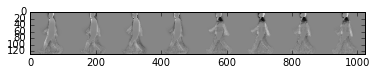

In [7]:
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(128, 8*128), cmap='gray')
print solver.net.blobs['label'].data[:8]

[ 0.  0.  1.  1.  2.  2.  3.  3.]


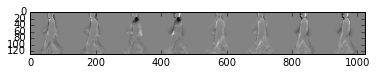

In [8]:
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(128, 8*128), cmap='gray')
print solver.test_nets[0].blobs['label'].data[:8]

In [9]:
solver.step(1)

In [10]:
%%time
niter = 5000
test_interval = 20
# losses will also be stored in the log
train_loss = zeros(niter)
test_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
#output = zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    
    #output[it] = solver.test_nets[0].blobs['ip2'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        #print 'Iteration', it, test_loss
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['fc8ft'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 3200.0
        test_loss[it] = solver.test_nets[0].blobs['loss'].data

Iteration 0 testing...
Iteration 20 testing...
Iteration 40 testing...
Iteration 60 testing...
Iteration 80 testing...
Iteration 100 testing...
Iteration 120 testing...
Iteration 140 testing...
Iteration 160 testing...
Iteration 180 testing...
Iteration 200 testing...
Iteration 220 testing...
Iteration 240 testing...
Iteration 260 testing...
Iteration 280 testing...
Iteration 300 testing...
Iteration 320 testing...
Iteration 340 testing...
Iteration 360 testing...
Iteration 380 testing...
Iteration 400 testing...
Iteration 420 testing...
Iteration 440 testing...
Iteration 460 testing...
Iteration 480 testing...
Iteration 500 testing...
Iteration 520 testing...
Iteration 540 testing...
Iteration 560 testing...
Iteration 580 testing...
Iteration 600 testing...
Iteration 620 testing...
Iteration 640 testing...
Iteration 660 testing...
Iteration 680 testing...
Iteration 700 testing...
Iteration 720 testing...
Iteration 740 testing...
Iteration 760 testing...
Iteration 780 testing...
Iterat

<function argmax>

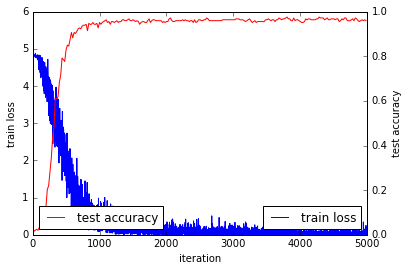

In [13]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss,label="train loss")
ax2.plot(test_interval * arange(len(test_acc)), test_acc,"r",label="test accuracy")
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax1.legend(loc="lower right")
ax2.legend(loc="lower left")


In [20]:
test_acc.max()


0.97562499999999996

In [46]:
%%time
niter = 100
test_interval = 20
# losses will also be stored in the log
train_loss = zeros(niter)
test_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 123))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    
    output[it] = solver.test_nets[0].blobs['fc8ft'].data[:8]
    

CPU times: user 1min 22s, sys: 28.4 s, total: 1min 50s
Wall time: 1min 40s


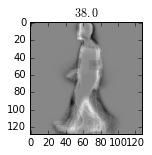

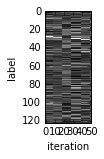

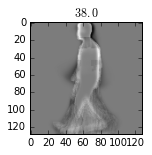

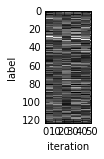

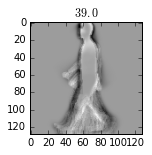

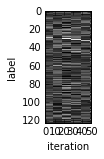

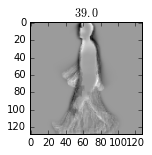

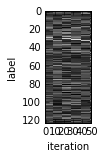

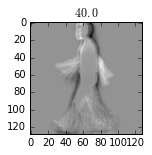

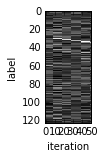

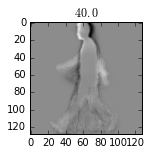

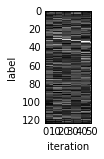

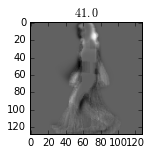

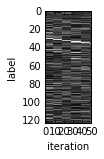

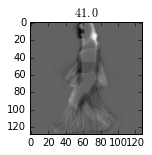

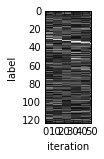

In [50]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    plt.title(r"$%s$"%solver.test_nets[0].blobs['label'].data[i])
    figure(figsize=(10, 2))
    imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')

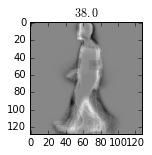

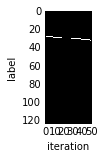

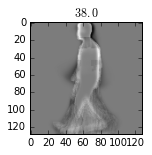

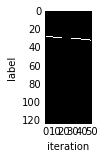

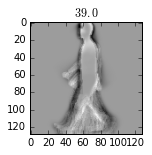

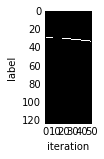

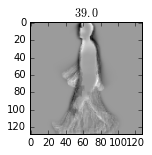

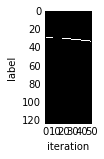

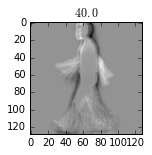

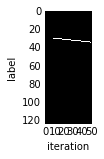

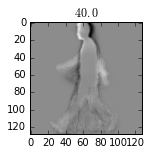

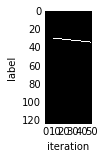

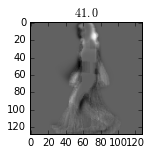

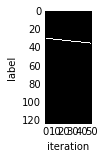

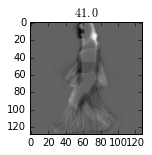

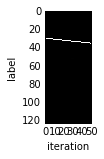

In [51]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    plt.title(r"$%s$"%solver.test_nets[0].blobs['label'].data[i])
    figure(figsize=(10, 2))
    imshow(exp(output[:50, i].T) / exp(output[:50, i].T).sum(0), interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')